In [1]:
import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

# import warnings
# warnings.filterwarnings('ignore')

# Using Logistic Regression on Titanic Dataset

## Define the problem

**Given**: dataset with various information about the Titanic passengers (age, sex, socio-economic status, cabin,...) 

**Goal**: analysis of what sorts of people were likely to survive.
    

## Prepare the data (Data Preprocessing)

### Load the data

We'll use the datasets provided by kaggle:[titanic/data](https://www.kaggle.com/c/titanic/data).

In [2]:
train_csv = 'https://raw.githubusercontent.com/geekcourses/JupyterNotebooksExamples/master/datasets/Titanic/train.csv'
test_csv='https://raw.githubusercontent.com/geekcourses/JupyterNotebooksExamples/master/datasets/Titanic/test.csv'

In [3]:
# load the dataset, using PassengerId as index
df_train = pd.read_csv(train_csv, index_col='PassengerId')
df_test = pd.read_csv(test_csv, index_col='PassengerId')

df_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Data variable descriptions:
<pre>
survival        Survival
                (0 = No; 1 = Yes)
pclass          Passenger Class
                (1 = 1st; 2 = 2nd; 3 = 3rd)
name            Name
sex             Sex
age             Age
sibsp           Number of Siblings/Spouses Aboard
parch           Number of Parents/Children Aboard
ticket          Ticket Number
fare            Passenger Fare
cabin           Cabin
embarked        Port of Embarkation
                (C = Cherbourg; Q = Queenstown; S = Southampton)

SPECIAL NOTES:
Pclass is a proxy for socio-economic status (SES)
 1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower

Age is in Years; Fractional if Age less than One (1)
 If the Age is Estimated, it is in the form xx.5
</pre>

### Get insight of the data (Prepare and clean)

In [4]:
print(df_train.shape)
print(df_test.shape)

(891, 11)
(418, 10)


In [5]:
print(df_train.info())
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null

#### Visualize with Seaborn

In [6]:
df_train.shape

(891, 11)

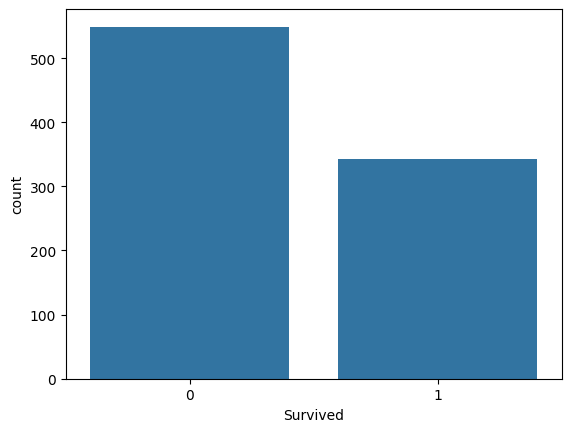

In [7]:
sns.countplot(x='Survived', data=df_train);

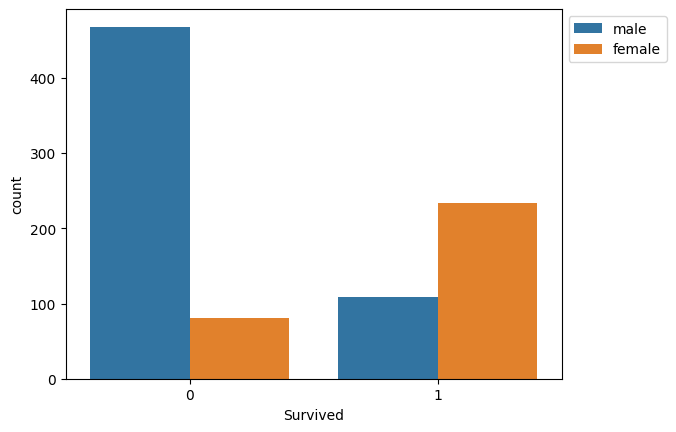

In [8]:
sns.countplot(x='Survived', hue='Sex', data=df_train)
plt.legend(bbox_to_anchor=(1, 1), loc=2);

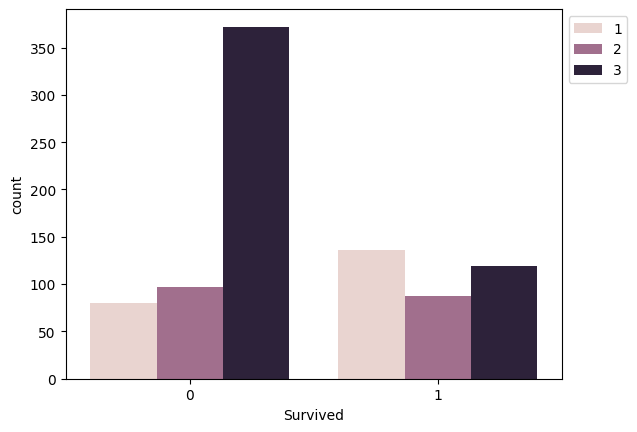

In [9]:
sns.countplot(x='Survived', hue='Pclass', data=df_train)
plt.legend(bbox_to_anchor=(1, 1), loc=2);

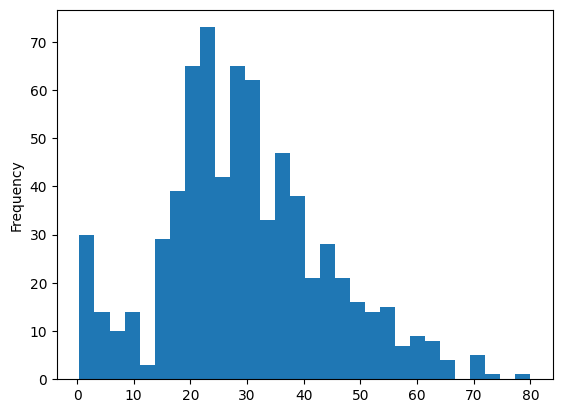

In [10]:
df_train['Age'].plot.hist(bins=30);

### Clean and wrangle the data

#### Remove Unnecessary Columns

Let's remove the 'Name', 'Ticket', and 'Cabin' columns as we can assume they are not relevant to whether the passenger survived.

In [11]:
df_train = df_train.drop(columns=['Name', 'Ticket', 'Cabin'])
df_test = df_test.drop(columns=['Name', 'Ticket', 'Cabin'])

#### Check for NaN values

In [12]:
print(df_train.isnull().sum())
print(df_test.isnull().sum())

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64
Pclass       0
Sex          0
Age         86
SibSp        0
Parch        0
Fare         1
Embarked     0
dtype: int64


Columns 'Age', 'Embarked' and 'Fare' <span style="color:red">has NaN</span> values. We have to deal with them.

#### Deal with NaN values

'Embarked' contains categorical data, so we will replace the NaN values with the most common value.

'Age' and 'Fare' missing values is reasonable to fill with respective medians.


In [13]:
# Concatenate the training and test dataframes for filling missing values consistently
combined_df = pd.concat([df_train, df_test])

# Find the most common value in the 'Embarked' column of the combined dataframe
most_common_embarked = combined_df["Embarked"].value_counts().idxmax()

# Fill missing 'Embarked' values with the most common value
df_train["Embarked"] = df_train["Embarked"].fillna(most_common_embarked)
df_test["Embarked"] = df_test["Embarked"].fillna(most_common_embarked)

# Fill missing 'Age' values with the median age of passengers in the combined dataframe
median_age = combined_df["Age"].median()
df_train["Age"] = df_train["Age"].fillna(median_age)
df_test["Age"] = df_test["Age"].fillna(median_age)

# Fill missing 'Fare' values with the median fare of passengers in the combined dataframe
median_fare = combined_df["Fare"].median()
df_test["Fare"] = df_test["Fare"].fillna(median_fare)


In [14]:
# Let's check again for NaN  values:
print(df_train.isnull().sum())
print(df_test.isnull().sum())

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


#### Convert Categorical Text Data to Numerical Values

Let's check which columns contain categorical data.

Categorical data typically have a data type of `object` (for text data) or `category`

In [26]:
# Identify columns with categorical data types (object or category)
categorical_columns = combined_df.select_dtypes(include=['object', 'category']).columns

print("Categorical columns:", categorical_columns)

Categorical columns: Index(['Sex', 'Embarked'], dtype='object')


We see that Sex and Embarked columns are not numerical. We will have to convert them to numbers.

In [16]:
def convert_categorical_to_numerical(df):
    if df['Sex'].dtype == "object":
        # convert 'Sex' column to numerical values: male=0, female=1
        df["Sex"] = df["Sex"].map({"male": 0, "female": 1})

    if df['Embarked'].dtype == "object":
        # Convert 'Embarked' column to numerical values: S=0, C=1, Q=2
        df["Embarked"] = df["Embarked"].map({"S": 0, "C": 1, "Q": 2})

    return df

In [17]:
df_train = convert_categorical_to_numerical(df_train)
df_test = convert_categorical_to_numerical(df_test)

## Select Features


### Show Correlations

<Axes: >

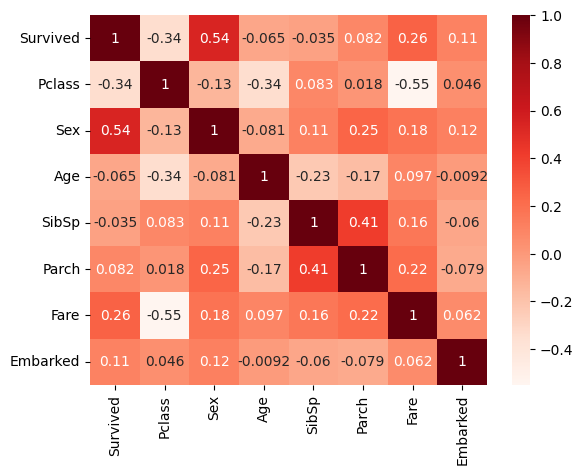

In [18]:
df_train_corr = df_train.corr()
sns.heatmap(df_train_corr,annot=True, cmap="Reds")

From the heat map we can see that 'Sex', 'Pclass','Fare' and 'Embarked' have the highest weight for 'Survived'. And we will use them as features.


<!-- ### Drop columns we won't use -->

In [19]:
usefull_features = ['Sex', 'Pclass','Fare','Embarked']

X_train = df_train[ usefull_features ]
y_train = df_train['Survived']

X_test = df_test[ usefull_features ]
y_test = df_test['Survived']

## Choose the model

The problem is a categorization one, and we are going to try first with LogisticRegression.

In [20]:
from sklearn.linear_model import LogisticRegression

## Train the model (fit the model)

In [21]:
# instantiate and fit the model
lg = LogisticRegression(solver='lbfgs') # we specify excplicit solver to suppress warnings
fitted = lg.fit(X_train,y_train)

### Make predictions

In [22]:
# let's check the "learned" co-efficients:
print(fitted.intercept_)
print(fitted.coef_)

[0.46493561]
[[ 2.51236594e+00 -9.19965120e-01  1.20899801e-03  2.89491900e-01]]


## Predict (classify unknown input sample)

In [23]:
y_pred = fitted.predict(X_test)

In [24]:
print(y_pred.shape)
print(y_test.shape)

(418,)


NameError: name 'y_test' is not defined

In [ ]:
# lets see how many correct answers we have:
res = y_pred == y_test
true_count = res[res==True]

print(f'Correct answers: {true_count.count()} out of {y_pred.size}')

Correct answers: 173 out of 223


## Evaluate the model

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.82      0.81       134
           1       0.72      0.71      0.72        89

    accuracy                           0.78       223
   macro avg       0.77      0.76      0.77       223
weighted avg       0.78      0.78      0.78       223

